# Preference learning

#### Autorzy: Filip Marciniak 148148, Szymon Pasternak 148146

# Zbiór danych

Jako zbiór danych wybraliśmy `mammographic`.

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error
from xgboost import plot_tree

In [2]:
df = pd.read_csv(
    'data/mammographic.csv',
    header=None,
    names=['one', 'two', 'three', 'four', 'five', 'class']
)
X, y = df.drop(columns=['class']), df['class']

In [3]:
X.describe()

,one,two,three,four,five
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,0.079890,0.484384,0.593976,0.453313,0.638554
std,0.034334,0.188100,0.414120,0.391794,0.116979
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072727,0.358974,0.333333,0.000000,0.666667
50%,0.072727,0.500000,0.666667,0.500000,0.666667
75%,0.090909,0.615385,1.000000,0.750000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
y.value_counts()

class
0.0    427
1.0    403
Name: count, dtype: int64

Zbiór danych posiada 5 kryteriów i klasę decyzyjną. W zbiorze zawartych jest 830 przykładów. Nie ma danych brakujących, czyli NULL. Każda z cech zawiera liczby rzeczywiste od 0 do 1. Klasa decyzyjna oznaczona jest jako 0 lub 1. Dane są zbalansowane, zawartych jest mniej więcej tyle samo przypadków z każdej klasy.

# Prosty interpretowalny model - XGBoost

## Trenowanie modelu

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = xgb.XGBClassifier(max_depth=3, n_estimators=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred)
f1_train = f1_score(y_train, y_pred)
auc_train = roc_auc_score(y_train, y_pred)

y_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
auc_test = roc_auc_score(y_test, y_pred)

print(f"TRAIN: Accuracy: {accuracy_train:.2%}, F1: {f1_train:.2%}, AUC: {auc_train:.2%}")
print(f"TEST: Accuracy: {accuracy_test:.2%}, F1: {f1_test:.2%}, AUC: {auc_test:.2%}")

TRAIN: Accuracy: 84.74%, F1: 83.43%, AUC: 84.69%
TEST: Accuracy: 84.34%, F1: 79.37%, AUC: 83.18%


## Wizualizacja modelu

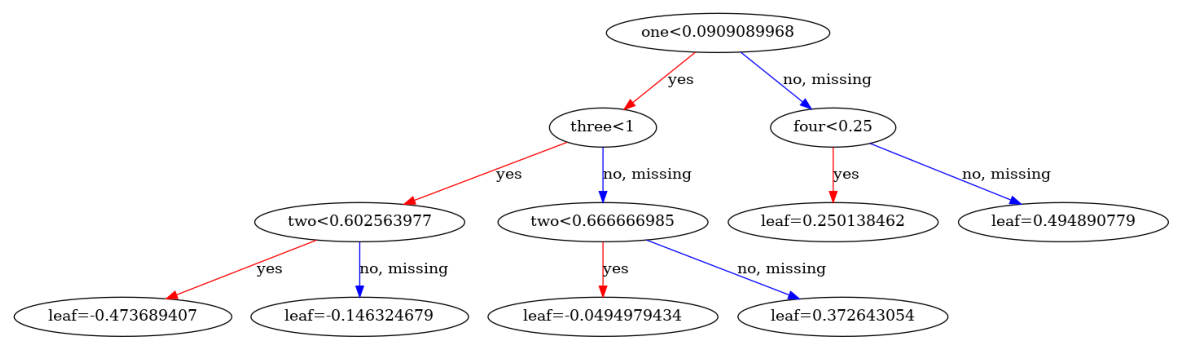

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(model, ax=ax, num_trees=0, fontsize=20);

## Interpretacja wizualizacji

Dzięki zaprezentowanej wizualizacji widzimy w jaki sposób wygląda zbudowane drzewo decyzyjne. Interpretacja takiego drzewa jest stosunkowo prosta - w celu klasyfikacji danego przykładu danych zaczynamy od korzenia i odpowiadamy na kolejne pytania, które zadawane są w poszczególnych węzłach. W liściach drzewa znajdują się wartości które podstawiamy do wzoru [1]

$$ \sigma(x) = \frac{1}{1 + e^{leaf}} $$

i w ten sposób obliczamy odpowiednie prawdopodobieństwo, na podstawie którego przypisujemy dany przypadek do klasy. \
W drzewie wyróżnić można dwa główne poddrzewa - prawe oraz lewe które zaczynają się od korzenia. W prawym korzeniu wszystkie przypadki trafiają do klasy 1, a w lewym znajduje się jedynie jeden liść, który zaklasyfikuje przypadki jako 1, a reszta jako 0 (przyjmując threshold dla sigmoidy jako x=0).

## Wyjaśnienie wybranych decyzji

### Wyjaśnienie decyzji dla 3 wybranych wariantów

Pobranie 3 losowych próbek ze zbioru danych:

In [21]:
df_sample = df.sample(3, random_state=21)
X_sample, y_sample = df_sample.drop(columns=['class']), df_sample['class']

Wykonanie predykcji na pobranych próbkach

In [22]:
y_pred = model.predict(X_sample)
X_sample['pred'] = y_pred
X_sample['true'] = y_sample
X_sample

,one,two,three,four,five,pred,true
452,0.072727,0.743590,1.000000,0.75,0.666667,1,0.0
601,0.072727,0.512821,0.333333,0.00,0.333333,0,0.0
678,0.090909,0.166667,1.000000,0.75,0.333333,1,1.0


**Wariant 452.** \
Został przypisany do klasy 1, ponieważ na atrybucie "one" posiada wartość mniejszą niż 0.09 i trafił do lewego poddrzewa. Następnie na pytanie three<1 odpowiedź brzmiała "no", a na pytaniu two<0.66 odpowiedź również brzmiała no. W taki sposób trafił do liście z wartością leaf=0.373, co sprawiło, że została przypisana mu klasa 1.

**Wariant 601.** \
Został przypisany do klasy 0, ponieważ na atrybucie "one" posiada wartość mniejszą niż 0.09 i trafił do lewej poddrzewa. Następnie w przeciwieństwie do poprzedniego wariantu na pytaniu three<1 odpowiedź brzmiała "yes", ponieważ posiada na nim wartość 0.33. W ten sposób trafił do liścia z ujemną wartością, co sprawiło, że została przypisana mu klasa 0.

**Wariant 678.** \
Został przypisany do klasy 1, ponieważ na atrybucie "one" posiada wartość większą niż 0.09 i trafił do prawego poddrzewa, w którym wszystkie liście (bez znaczenia na następne pytanie) przypisują klasę 1.

### Minimalna zmiana w ocenach 3 wariantów

#### Metoda analityczna

Dokonanie zmian w analizowanych przykładach

In [23]:
X_change = X_sample.copy()
X_change.loc[452, "three"] = 0.999
X_change.loc[601, "one"] = 0.091
X_change.loc[678, "one"] = 0.09

Wykonanie predykcji na wybranych przykładach

In [25]:
y_pred = model.predict(X_change[['one', 'two', 'three', 'four', 'five']])
X_change['pred_new'] = y_pred
X_change['true'] = y_sample
X_change

,one,two,three,four,five,pred,true,pred_new
452,0.072727,0.743590,0.999000,0.75,0.666667,1,0.0,0
601,0.091000,0.512821,0.333333,0.00,0.333333,0,0.0,1
678,0.090000,0.166667,1.000000,0.75,0.333333,1,1.0,0


Po dokonaniu zmian w wartościach można zaobserwować, że dla każdego z przykładów zostały przypisane inne klasy niż poprzednio. Nowe predykcje widoczne są w kolumnie `pred_new`, a oryginalne w `pred`. W kolumnie `true` umieszczone zostały prawdziwe klasy. 

Opis dokonanych zmian:
**Wariant 452** \
Ten wariant miał przypisaną klasę 1, więc należało zmienić ją na 0. Można to uzyskać poprzez zmniejszenie o niewielką wartość atrybutu "three" - ustawić na wartość mniejszą od 1. Wówczas przypadek trafia do najbardziej lewego poddrzewa i przypisywana jest mu klasa 0.

**Wariant 601** \
Ten wariant miał przypisaną klasę 0, więc należało zmienić ją na 1. Wystarczyło zmienić o niewielką wartość (około 0.02) wartość na atrybucie "one", aby w pierwszym pytaniu zamiast na lewą stronę, przypadek znalazł się po prawej stronie drzewa i została mu przypisana klasa 1.

**Wariant 678** \
Ten wariant miał przypisaną klasę 1, więć należało zmienić ją na 0. Można to było uzyskać ponownie poprzez niewielką zmianę na atrybucie "one" - zmiana z 0.0909 na 0.09. Pozostałe atrybuty mogły pozostać niezmienione.

#### Próbkowanie przestrzeni

In [49]:
STEP = 0.01
variants = X_sample.index.to_list()
best_solution = None

for variant in variants:
    min_distance = 1
    best_solution = None
    for attribute in X.columns:
        X_new = pd.DataFrame(X.loc[variant, :]).T
        for value in np.arange(0, 1, 0.001):
            X_new.loc[variant, attribute] = value
            y_pred = model.predict(X_new)
            
            new_distance = mean_absolute_error(
                X.loc[variant, :],
                X_new.loc[variant, :]
            )
            if y_pred[0] != X_change.loc[variant, "pred"] and new_distance < min_distance:
                min_distance = new_distance
                best_solution = X_new.copy()
    print(best_solution)

          one      two  three  four      five
452  0.072727  0.74359  0.999  0.75  0.666667
       one       two     three  four      five
601  0.091  0.512821  0.333333   0.0  0.333333
      one       two  three  four      five
678  0.09  0.166667    1.0  0.75  0.333333


Próbkowanie przetrzeni przyniosło podobne rezultaty i obserwacje do tych, które zostały osiągnięte metodą analityczną. Dla wariantu 452 należy zmniejszyć nieco wartość na atrybucie "three", dla wariantu 601 podnieść wartość na atrybucie "one", a dla wariantu 678 obniżyć wartość na atrybucie "one".

### Wyjaśnienie decyzji za pomocą wyspecjalizowanej techniki

Jako technikę zdecydowaliśmy się wybrać bibliotekę `shap` ze względu na duża liczbę dostępnych przykładów w dokumentacji oraz przejrzystość w oferowanych przez bibliotekę metodach.

In [66]:
import shap

In [72]:
explainer = shap.Explainer(model)
df_sample = df.sample(3, random_state=21)
X_sample = df_sample.drop(columns=['class'])
shap_values = explainer(X_sample)

**Wariant 452**

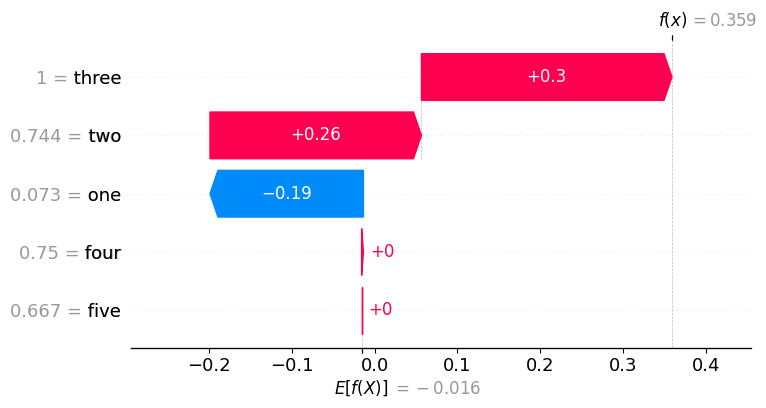

In [73]:
shap.plots.waterfall(shap_values[0])

Na wizualizacji widać potwierdzenie wcześniejszego omówienie - na podstawie wartości na atrybutach two i three wariant uzyskuje klasę 1.

**Wariant 601**

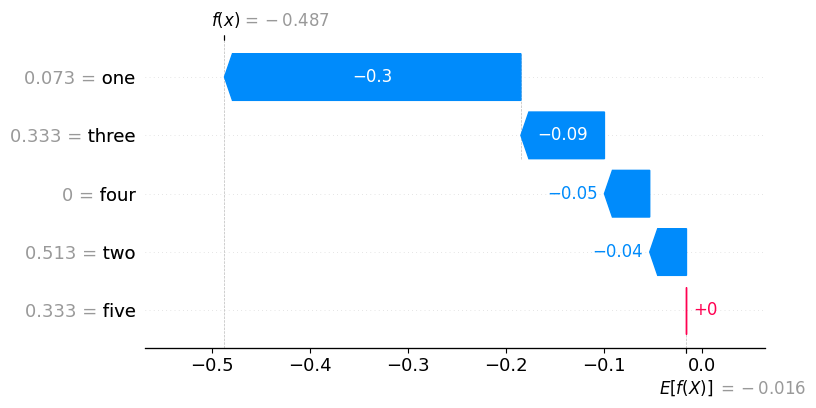

In [74]:
shap.plots.waterfall(shap_values[1])

Wszystkie wartości na atrybutach one, three i two, wskazują, że wariant uzyskuje klasę 0.

**Wariant 678**

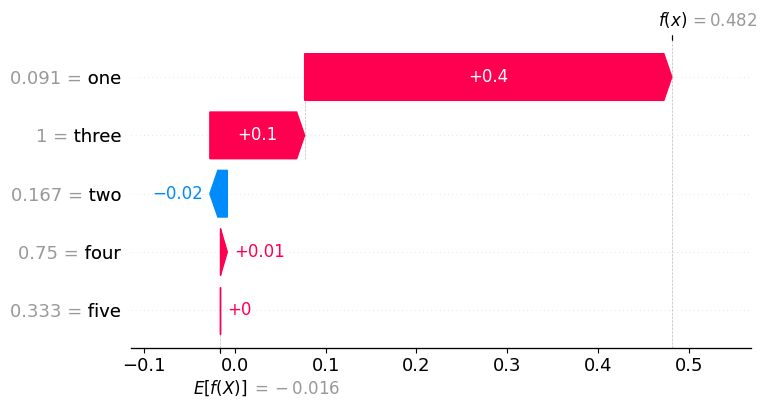

In [75]:
shap.plots.waterfall(shap_values[2])

Podobnie jak w poprzednich omawianych przykładach, największe znaczenie ma atrybut one, dla którego uzyskana wartość większa równa 0.0909 powoduje, że wariant uzyskuje klasę 1.

## Interpretacja modelu

### Preferencje użytkowników



### Wpływ każdego z kryteriów

### Charakter kryteriów

### Progi preferencji

### Wykorzystanie Partial Dependence Plot

# Źródła

[1] https://stackoverflow.com/a/50940011/16191733